In [ ]:
!pip install sklearn

In [1]:
from datetime import datetime
import os as os
import pandas as pandas
import pickle as pickle
import pyspark as pyspark

In [2]:
def poloUrl(pair, start, end, period):
    return 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'.format(pair, start.timestamp(), end.timestamp(), period)

In [15]:
def pairUrl(pair):
    start = datetime.strptime('2015-01-01', '%Y-%m-%d')
    end = datetime.now()
    period = 86400
    return poloUrl(pair, start, end, period)

In [4]:
def cachedPath(pair):
    return pair

In [5]:
def cachedPair(pair):
    path = cachedPath(pair)
    if os.path.exists(path): 
        print('Load From Cache: {}'.format(path))
        file = open(path, 'rb')
        data = pickle.load(file)
        return data
    return None

In [6]:
def downloadPair(pair):
    url = pairUrl(pair)
    print('Downloading {}'.format(url))
    data = pandas.read_json(url)
    return data
    

In [7]:
def getPair(pair):
    data = cachedPair(pair)
    # data = None
    if data is None:
        data = downloadPair(pair)
        data.to_pickle(cachedPath(pair))
    return data.set_index('date')

In [8]:
def calRaised(data):
    data['raised'] = data['close'] > data['open']
    return data

In [9]:
def seriesToSupervised(data, nIn, nOut, dropnan = True):
    nVars = data.shape[1]
    cols, names = list(), list()
    for i in range(nIn, 0, -1):
        cols.append(data.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(nVars)]
    for i in range(0, nOut):
        cols.append(data.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(nVars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(nVars)]
    agg = pandas.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    agg.drop( [('var%d(t)' % (j+1)) for j in range(1, nVars)], axis=1)
    return agg

In [19]:
data = seriesToSupervised(calRaised(getPair('USDT_ETH')), 60, 1, True)



train = data.loc["2016-10-01":"2017-9-30"].values
test = data.loc["2017-10-01":].values

trainX, trainY = train[:, :-1], train[:, -1]
testX, testY = test[:, :-1], test[:, -1]

#print(trainX.shape, trainY.shape, testX.shape, testY.shape)

trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))

print(trainX.shape, trainY.shape, testX.shape, testY.shape)

Load From Cache: USDT_ETH
(365, 1, 487) (365,) (96, 1, 487) (96,)


In [22]:
from keras import *
from keras.models import *
from keras.layers import *

# design network
model = Sequential()
model.add(LSTM(150, input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network

history = model.fit(trainX,
                    trainY,
                    epochs=300,
                    batch_size=80,
                    validation_data=(testX, testY), verbose=1, shuffle=False)

Train on 365 samples, validate on 96 samples
Epoch 1/300
365/365 [==============================] - 2s 6ms/step - loss: 0.5237 - acc: 0.4849 - val_loss: 0.5311 - val_acc: 0.4375
Epoch 2/300
365/365 [==============================] - 0s 506us/step - loss: 0.4934 - acc: 0.4849 - val_loss: 0.5116 - val_acc: 0.4375
Epoch 3/300
365/365 [==============================] - 0s 558us/step - loss: 0.4927 - acc: 0.4986 - val_loss: 0.4975 - val_acc: 0.5208
Epoch 4/300
365/365 [==============================] - 0s 599us/step - loss: 0.4714 - acc: 0.5233 - val_loss: 0.4846 - val_acc: 0.5625
Epoch 5/300
365/365 [==============================] - 0s 635us/step - loss: 0.4618 - acc: 0.5562 - val_loss: 0.4723 - val_acc: 0.5417
Epoch 6/300
365/365 [==============================] - 0s 522us/step - loss: 0.4410 - acc: 0.6247 - val_loss: 0.4589 - val_acc: 0.5625
Epoch 7/300
365/365 [==============================] - 0s 584us/step - loss: 0.4236 - acc: 0.6603 - val_loss: 0.4475 - val_acc: 0.5521
Epoch 8/300


Epoch 61/300
365/365 [==============================] - 0s 738us/step - loss: 0.2405 - acc: 0.8904 - val_loss: 0.4392 - val_acc: 0.5521
Epoch 62/300
365/365 [==============================] - 0s 678us/step - loss: 0.2217 - acc: 0.9260 - val_loss: 0.4285 - val_acc: 0.6146
Epoch 63/300
365/365 [==============================] - 0s 685us/step - loss: 0.2275 - acc: 0.9068 - val_loss: 0.4300 - val_acc: 0.5833
Epoch 64/300
365/365 [==============================] - 0s 590us/step - loss: 0.2197 - acc: 0.9233 - val_loss: 0.4330 - val_acc: 0.5625
Epoch 65/300
365/365 [==============================] - 0s 536us/step - loss: 0.2207 - acc: 0.9288 - val_loss: 0.4341 - val_acc: 0.5625
Epoch 66/300
365/365 [==============================] - 0s 879us/step - loss: 0.2307 - acc: 0.9342 - val_loss: 0.4353 - val_acc: 0.5417
Epoch 67/300
365/365 [==============================] - 0s 785us/step - loss: 0.2164 - acc: 0.9288 - val_loss: 0.4321 - val_acc: 0.5625
Epoch 68/300
365/365 [==========================

365/365 [==============================] - 0s 542us/step - loss: 0.1600 - acc: 0.9863 - val_loss: 0.4344 - val_acc: 0.5938
Epoch 122/300
365/365 [==============================] - 0s 533us/step - loss: 0.1696 - acc: 0.9863 - val_loss: 0.4264 - val_acc: 0.6250
Epoch 123/300
365/365 [==============================] - 0s 543us/step - loss: 0.1575 - acc: 0.9890 - val_loss: 0.4301 - val_acc: 0.6146
Epoch 124/300
365/365 [==============================] - 0s 526us/step - loss: 0.1518 - acc: 0.9836 - val_loss: 0.4330 - val_acc: 0.6250
Epoch 125/300
365/365 [==============================] - 0s 519us/step - loss: 0.1599 - acc: 0.9890 - val_loss: 0.4301 - val_acc: 0.6250
Epoch 126/300
365/365 [==============================] - 0s 527us/step - loss: 0.1609 - acc: 0.9836 - val_loss: 0.4316 - val_acc: 0.6354
Epoch 127/300
365/365 [==============================] - 0s 548us/step - loss: 0.1651 - acc: 0.9726 - val_loss: 0.4315 - val_acc: 0.6354
Epoch 128/300
365/365 [==============================] 

Epoch 181/300
365/365 [==============================] - 0s 486us/step - loss: 0.1522 - acc: 0.9918 - val_loss: 0.4346 - val_acc: 0.5833
Epoch 182/300
365/365 [==============================] - 0s 530us/step - loss: 0.1441 - acc: 0.9973 - val_loss: 0.4348 - val_acc: 0.5833
Epoch 183/300
365/365 [==============================] - 0s 547us/step - loss: 0.1552 - acc: 0.9973 - val_loss: 0.4397 - val_acc: 0.5729
Epoch 184/300
365/365 [==============================] - 0s 520us/step - loss: 0.1522 - acc: 0.9890 - val_loss: 0.4398 - val_acc: 0.5729
Epoch 185/300
365/365 [==============================] - 0s 522us/step - loss: 0.1431 - acc: 0.9890 - val_loss: 0.4428 - val_acc: 0.5729
Epoch 186/300
365/365 [==============================] - 0s 486us/step - loss: 0.1477 - acc: 0.9945 - val_loss: 0.4439 - val_acc: 0.5729
Epoch 187/300
365/365 [==============================] - 0s 545us/step - loss: 0.1319 - acc: 1.0000 - val_loss: 0.4441 - val_acc: 0.5833
Epoch 188/300
365/365 [==================

365/365 [==============================] - 0s 866us/step - loss: 0.1367 - acc: 0.9945 - val_loss: 0.4380 - val_acc: 0.5833
Epoch 242/300
365/365 [==============================] - 0s 753us/step - loss: 0.1323 - acc: 0.9973 - val_loss: 0.4398 - val_acc: 0.6146
Epoch 243/300
365/365 [==============================] - 0s 807us/step - loss: 0.1382 - acc: 0.9918 - val_loss: 0.4322 - val_acc: 0.5833
Epoch 244/300
365/365 [==============================] - 0s 969us/step - loss: 0.1385 - acc: 0.9890 - val_loss: 0.4332 - val_acc: 0.6042
Epoch 245/300
365/365 [==============================] - 0s 697us/step - loss: 0.1326 - acc: 1.0000 - val_loss: 0.4408 - val_acc: 0.6250
Epoch 246/300
365/365 [==============================] - 0s 753us/step - loss: 0.1408 - acc: 0.9945 - val_loss: 0.4407 - val_acc: 0.6354
Epoch 247/300
365/365 [==============================] - 0s 624us/step - loss: 0.1308 - acc: 0.9945 - val_loss: 0.4421 - val_acc: 0.6146
Epoch 248/300
365/365 [==============================] 

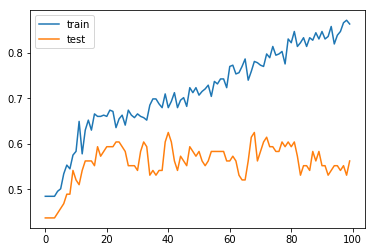

0.871232881938
98
0.625
68


In [21]:
from matplotlib import pyplot

# plot history
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()
print(max(history.history['acc']))
print(history.history['acc'].index(max(history.history['acc'])))
print(max(history.history['val_acc']))
print(history.history['val_acc'].index(max(history.history['val_acc'])))

In [ ]:
# make a prediction
yhat = model.predict(testX)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, testX[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(testY), 1))
inv_y = concatenate((testY, testX[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(invY)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)